In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import torch
#import torchvision
from torch.utils.data import DataLoader
#from torchvision import transforms
from torch.utils.data import Dataset,SubsetRandomSampler,Sampler
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch import optim
import glob
from skimage import io, transform
from PIL import Image
import random
import PIL.ImageEnhance as ie
import copy
from torch.autograd import Variable
import PIL.Image as im
from math import floor
%matplotlib inline 
import librosa


In [2]:
!pip3 install torchaudio

Shape of waveform: torch.Size([1, 4261])
Sample rate of waveform: 8000
<class 'torch.Tensor'>


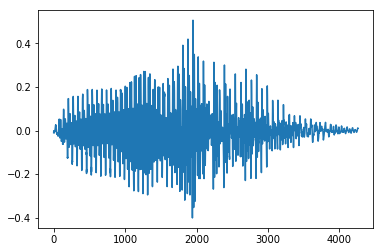

In [3]:
import torchaudio
import matplotlib.pyplot as plt
from torch import nn
filename = "../content/drive/My Drive/winter_assignment/audio-mnist-with-person-detection-master/recordings/0_jackson_1.wav"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
print(type(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

<class 'torch.Tensor'>
Shape of spectrogram: torch.Size([1, 201, 22])


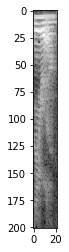

In [5]:
specgram = torchaudio.transforms.Spectrogram()(waveform)
print(type(specgram))
print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

Shape of spectrogram: torch.Size([1, 120, 20])


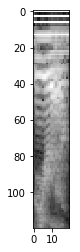

In [6]:
specgram = torchaudio.transforms.MelSpectrogram()(waveform)
specgram = specgram[ : , :120 , :20]

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='gray')

In [0]:
def extract_name_digit(file):
    parts = file.split("_")
    digit = int(parts[0])
    name = parts[1]
    if PEOPLE.get(name) == None:
        name = "other"
        
    return name, digit

In [0]:
def wav_info_extractor(dirpath, ext):
    path = "../content/drive/My Drive/winter_assignment/audio-mnist-with-person-detection-master/" + dirpath
    mfcc_vectors = []
    label_vectors = []
    digit_vectors = []
    file_vectors = []
    for file in os.listdir(path):
        if file.endswith(ext):
            file_path = os.path.join(path, file)
            
            name, digit = extract_name_digit(file)
            
            digit_vectors.append(digit)
            file_vectors.append(file_path)
    
    
    digits = np.array(digit_vectors)
    digits = np.reshape(digits, (digits.shape[0], 1))
    
    files = np.array(file_vectors)
    
    return digits, files

In [0]:

N_PEOPLE = 4
N_DIGITS = 10
PEOPLE = {"jackson":0, "nicolas":1, "theo":2, "other":3}
digits, files = wav_info_extractor(dirpath="recordings/", ext=".wav")


MelSpectogram after padding


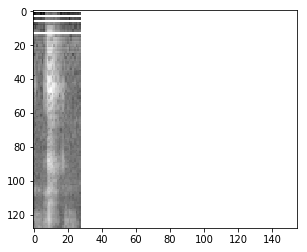

In [17]:
print("MelSpectogram after padding")
#for i in range(1):
image_name = files[1]
waveform,sr = torchaudio.load(image_name)
specgram = torchaudio.transforms.MelSpectrogram()(waveform)
a = specgram.shape
target = torch.zeros(128, 155)
for i in range(128):
  for j in range(specgram.shape[2]):
    target[i][j]=specgram[0][i][j]
plt.figure()
p = plt.imshow(target.log2()[:,:].detach().numpy(), cmap='gray')

In [0]:
class audioDataset(Dataset):
    

    def __init__(self, files,csv_file1, transform=None):
        self.data_frame = files
        self.transform = transform
        self.digits = csv_file1
        

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame[idx]
        waveform, sample_rate = torchaudio.load(img_name)
        specgram = torchaudio.transforms.MelSpectrogram()(waveform)
        target = torch.zeros(128, 155)
        for i in range(128):
          for j in range(specgram.shape[2]):
            b = specgram[0][i][j]
            target[i][j] = b
        label1 = self.digits[idx]
        labels = torch.zeros(10)
        for i in range(10):
          if i==label1:
            labels[i]=1
        #specgram = specgram[ : , :100, : 15]
        return(target, labels)
        

In [0]:
trainset = audioDataset(files=files,csv_file1 =digits , transform=transform)
valset   = audioDataset(files=files,csv_file1 =digits, transform=transform)


In [0]:
def train_valid_split(dataset, test_size = 0.20, shuffle = False, random_seed = 0):
    length = dataset.__len__()
    indices = list(range(1,length))
    
    if shuffle == True:
        random.seed(random_seed)
        random.shuffle(indices)
    
    if type(test_size) is float:
        split = floor(test_size * length)
    elif type(test_size) is int:
        split = test_size
    else:
        raise ValueError('%s should be an int or a float' % str)
    return indices[split:], indices[:split]

In [0]:
train_idx, valid_idx = train_valid_split(trainset, 0.20)
#train_sampler = torch.utils.data.WeightedRandomSampler(weight, len(train_idx))
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = DataLoader(dataset=trainset,sampler = train_sampler,batch_size=16)    
valid_loader = DataLoader(dataset = valset,batch_size=16, sampler=valid_sampler)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.dp1 = nn.Dropout(0.2)
        self.relu1 = nn.LeakyReLU()
        
        self.conv2 = nn.Conv2d(32, 64, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dp2 = nn.Dropout(0.2)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(64, 64, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dp3 = nn.Dropout(0.2)
        self.relu3 = nn.ReLU()
        
        self.linear4 = nn.Linear(64*127*154, 256)
        self.relu4 = nn.ReLU()
        self.dp4 = nn.Dropout(0.2)
        
        self.linear5 = nn.Linear(256, 128)
        self.relu5 = nn.ReLU()
        self.dp5 = nn.Dropout(0.2)
        
        self.linear6 = nn.Linear(128 , 10)
        self.softmax = nn.Softmax(dim=1)
      

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dp1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.dp2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.dp3(x)
        x = self.relu3(x)
        
        x = x.view(-1, 64*127*154)
        x = self.linear4(x)
        x = self.relu4(x)
        x = self.dp4(x)
        
        x = self.linear5(x)
        x = self.relu5(x)
        x = self.dp5(x)
        
        x = self.linear6(x)
        x = self.softmax(x)
        
        return x

In [35]:
net = Net()
net.cuda()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.2, inplace=False)
  (relu2): ReLU()
  (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp3): Dropout(p=0.2, inplace=False)
  (relu3): ReLU()
  (linear4): Linear(in_features=1251712, out_features=256, bias=True)
  (relu4): ReLU()
  (dp4): Dropout(p=0.2, inplace=False)
  (linear5): Linear(in_features=256, out_features=128, bias=True)
  (relu5): ReLU()
  (dp5): Dropout(p=0.2, inplace=False)
  (linear6): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(net.parameters(), lr=0.007)

In [0]:

for epoch in range(10):  # loop over the dataset multiple times
  
    net.train()
    valid_losses=[]
    
    for i,(inputs, labels) in enumerate(train_loader):
        
        
        inputs = inputs.unsqueeze(1)
        labels= labels.long()
        labels2 = torch.argmax(labels,1)
        inputs = inputs.cuda()
        labels2 = labels2.cuda()

        optimizer.zero_grad()
        

        outputs = net(inputs)
        loss = criterion(outputs,labels2)
        loss.backward()

        optimizer.step()
        
    correct =0
    total =0
    net.eval()
    for inputs, labels in valid_loader:
      inputs = inputs.unsqueeze(1)
      labels= labels.long()
      labels2 = torch.argmax(labels,1)
      inputs = inputs.cuda()
      labels2 = labels2.cuda()
      
      output = net(inputs)
      loss = criterion(output,labels2)
      valid_losses.append(loss.item())
      
      _, predicted = torch.max(output, 1)
      labels2 = torch.argmax(labels,1)
      
      correct += (predicted.cpu() == labels2.cpu()).sum()
      total += labels.size(0)
      
    valid_loss = np.average(valid_losses)
    print(valid_loss)
    print(correct)
    print(total)
    print("accuracy =",(correct*100)/total)
      
          


print('Finished Training')


2.226355218887329
tensor(98)
320
accuracy = tensor(30)
2.1710100889205934
tensor(133)
320
accuracy = tensor(41)
2.118089735507965
tensor(155)
320
accuracy = tensor(48)
2.0821285009384156
tensor(164)
320
accuracy = tensor(51)
2.0333098828792573
tensor(174)
320
accuracy = tensor(54)
2.0156844556331635
tensor(176)
320
accuracy = tensor(55)
1.997109407186508
tensor(176)
320
accuracy = tensor(55)
1.9734276175498962
tensor(179)
320
accuracy = tensor(55)
1.9716499984264373
tensor(177)
320
accuracy = tensor(55)
